# Credit Risk Scoring Model with AI
# ----------------------------------
# Objective: Predict credit risk (default vs non-default) using machine learning
# Dataset: Loan application data (df_2014-18_selected.csv)
# Techniques used: SMOTE, Random Forest, SHAP, GPT-2 for explanation
# ----------------------------------



In [2]:
# --- STEP 0: Setup & Imports ---
# Import libraries for data handling, ML, visualization, and transformers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import openai
import time

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE



In [3]:
# --- STEP 1: Load Dataset ---
# Load the dataset from local CSV file and sample for faster dev cycles

df = pd.read_csv('df_2014-18_selected.csv')
print("Initial data shape:", df.shape)
print("Available columns:", df.columns.tolist())

# Sample 30,000 rows to speed up modeling and plotting

df = df.sample(n=30000, random_state=42)
print("Sampled data shape:", df.shape)



Initial data shape: (2029952, 13)
Available columns: ['total_rec_late_fee', 'recoveries', 'last_pymnt_amnt', 'loan_amnt_div_instlmnt', 'debt_settlement_flag', 'loan_age', 'total_rec_int', 'out_prncp', 'time_since_last_credit_pull', 'time_since_last_payment', 'int_rate%', 'total_rec_prncp', 'loan_status_binary']
Sampled data shape: (30000, 13)


In [4]:
# --- STEP 2: Preprocess Data ---
# Set target variable

TARGET_COLUMN = 'loan_status_binary'
if TARGET_COLUMN not in df.columns:
    raise KeyError(f"'{TARGET_COLUMN}' not found in dataset. Please verify column names.")

# Move target to a new column for modeling

df['target'] = df[TARGET_COLUMN]
df = df.drop(columns=[TARGET_COLUMN])

# Fill missing numeric values with median

df = df.fillna(df.median(numeric_only=True))

# Label encode any categorical features

cat_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])



In [5]:
# --- STEP 3: Train/Test Split + Resample with SMOTE ---
# Split data into features and target

X = df.drop(columns=['target'])
y = df['target']

# Split into train/test sets with stratification

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Use SMOTE to handle class imbalance

print("Applying SMOTE...")
start_time = time.time()
smote = SMOTE(random_state=42, n_jobs=-1)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("SMOTE completed in", round(time.time() - start_time, 2), "seconds")

# Scale features for model stability

scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)



Applying SMOTE...
SMOTE completed in 0.1 seconds


C:\Users\amith\anaconda3\Lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [6]:
# --- STEP 4: Train Random Forest Model ---
# Train a RandomForest model with 50 trees and limited depth for performance

print("Training model...")
start_time = time.time()
model = RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42)
model.fit(X_train_res, y_train_res)
print("Model training completed in", round(time.time() - start_time, 2), "seconds")

# Save the model and scaler for reuse

joblib.dump(model, 'credit_risk_rf_model.pkl')
joblib.dump(scaler, 'scaler.pkl')



Training model...
Model training completed in 0.56 seconds


['scaler.pkl']

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       169
           1       0.99      0.99      0.99       831

    accuracy                           0.99      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.99      0.99      0.99      1000

ROC AUC: 0.9916120166050741


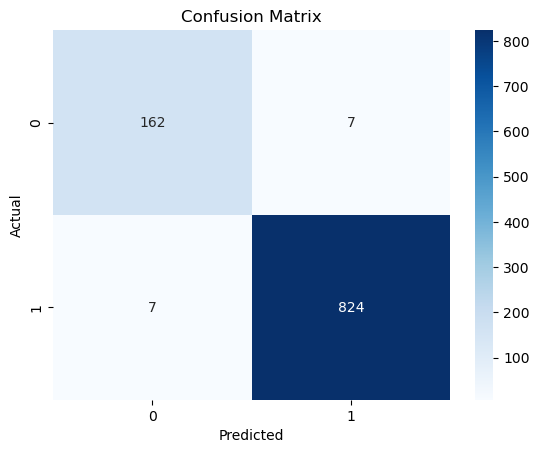

In [7]:
# --- STEP 5: Evaluate Model on Test Sample ---
# Evaluate model on a subset of test data for speed

X_test_small = X_test[:1000]
y_test_small = y_test[:1000]

# Predict classes and probabilities

y_pred = model.predict(X_test_small)
y_proba = model.predict_proba(X_test_small)[:, 1]

# Display performance metrics

print("Classification Report:\n", classification_report(y_test_small, y_pred))
print("ROC AUC:", roc_auc_score(y_test_small, y_proba))

# Plot confusion matrix

cm = confusion_matrix(y_test_small, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



<Figure size 640x480 with 0 Axes>

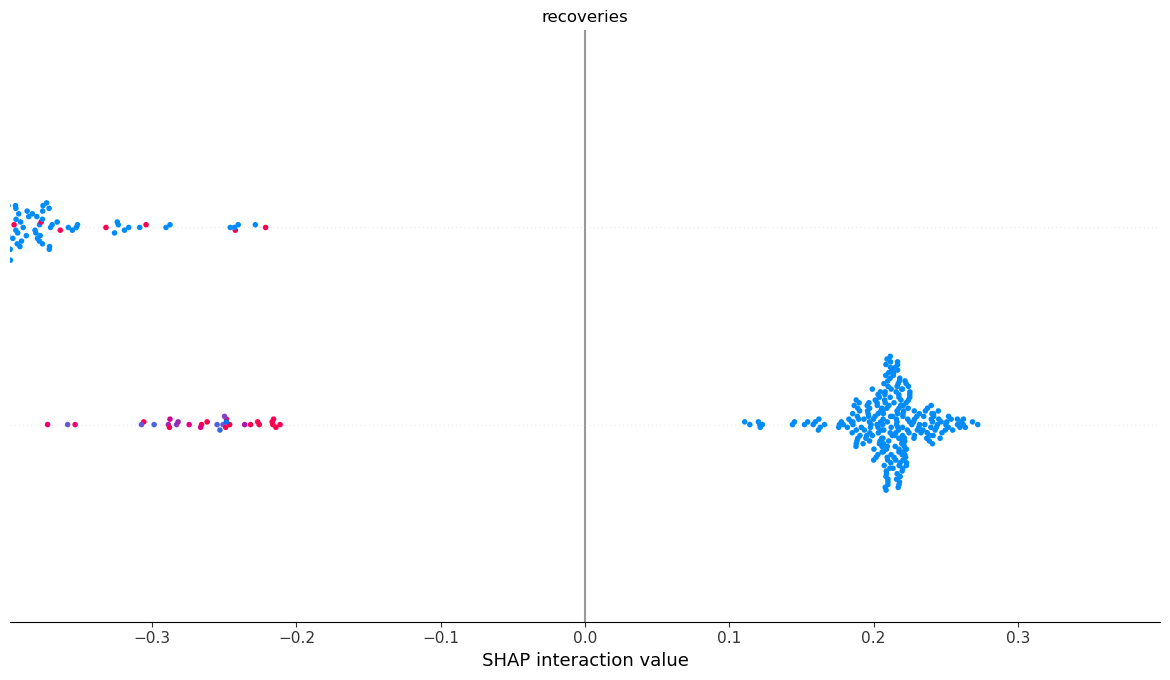

In [8]:
# --- STEP 6: Global SHAP Explanation ---
# Show SHAP values for feature importance explanation

explainer = shap.TreeExplainer(model)
X_sample = X_test_small[:300]
shap_values = explainer.shap_values(X_sample)

# Plot summary of most impactful features

if isinstance(shap_values, list) and len(shap_values) == 2:
    shap.summary_plot(shap_values[1], pd.DataFrame(X_sample, columns=X.columns))
else:
    shap.summary_plot(shap_values, pd.DataFrame(X_sample, columns=X.columns))


In [9]:
# --- STEP 7: Predict a Single Instance ---
# Make prediction for one user/sample

sample_input = X.iloc[0:1].copy()
sample_scaled = scaler.transform(sample_input)
pred = model.predict(sample_scaled)[0]
proba = model.predict_proba(sample_scaled)[0][1]

# Print prediction result

print("\n--- Sample Prediction ---")
print("Prediction:", "High Risk" if pred == 1 else "Low Risk")
print("Risk Score:", round(proba * 100, 2), "%")




--- Sample Prediction ---
Prediction: High Risk
Risk Score: 86.11 %


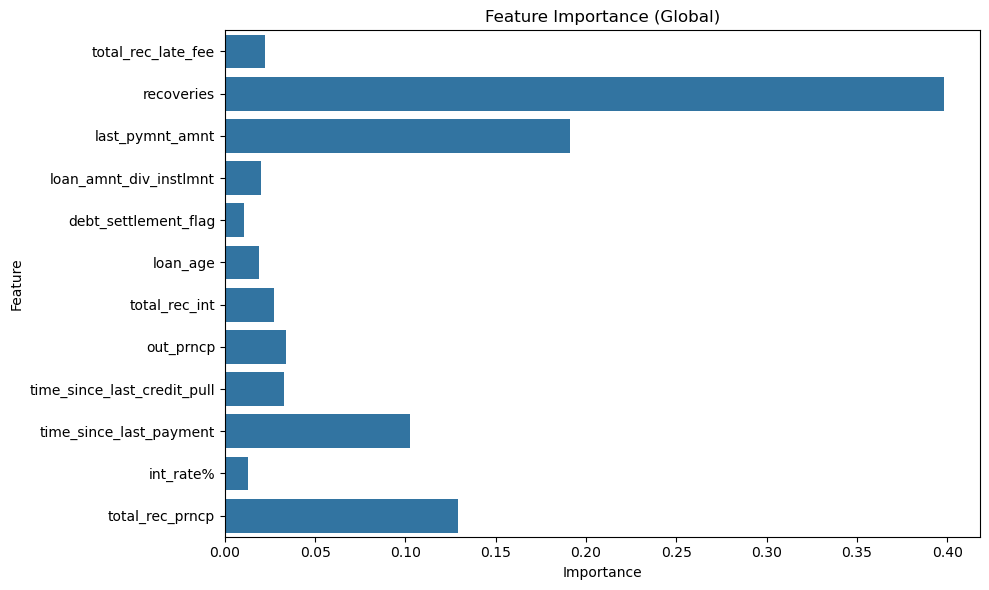

In [10]:
# Alternative to SHAP local: Global feature importances
importances = model.feature_importances_
features = X.columns

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance (Global)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [11]:
# --- STEP 8: Manual Risk Rule Explanation ---
# Apply some rule-based reasoning to explain the prediction

risk_factors = []

if 'loan_amnt' in sample_input.columns and sample_input['loan_amnt'].values[0] > 25000:
    risk_factors.append("High loan amount")
if 'dti' in sample_input.columns and sample_input['dti'].values[0] > 20:
    risk_factors.append("High debt-to-income ratio")
if 'loan_age' in sample_input.columns and sample_input['loan_age'].values[0] < 6:
    risk_factors.append("Recent loan account")

print("--- Manual Risk Explanation ---")
if pred == 1:
    print("Model predicted HIGH RISK due to:")
    if risk_factors:
        for factor in risk_factors:
            print(" •", factor)
    else:
        print(" • No specific rules matched, model may have found complex patterns")
else:
    print("Model predicted LOW RISK.")


--- Manual Risk Explanation ---
Model predicted HIGH RISK due to:
 • No specific rules matched, model may have found complex patterns


In [12]:
from transformers import pipeline

# --- STEP 9: LLM Explanation (GPT-2, Local) ---
# Generate human-like explanation using offline GPT-2 model

generator = pipeline("text-generation", model="gpt2", framework="pt")

prompt = "This person is marked high credit risk because they have a high loan amount and DTI. Explain simply:"
result = generator(prompt, max_length=50, num_return_sequences=1)

print("\nAI Explanation:")
print(result[0]['generated_text'])


Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



AI Explanation:
This person is marked high credit risk because they have a high loan amount and DTI. Explain simply: If you have 10% DTI, but you have a negative DTI score (1 (i.e. negative credit risk)) because your
